A ideia deste trabalho é analisar e extrair insights dos dados de infração disponíveis em: **http://repositorio.dados.gov.br/transportes-transito/transito/multas/infracaocondutor-2007-2013.zip**. A análise dos dados será feita na lingugem Python majoritariamente pela biblioteca Pandas e suas funções.

In [1]:
import pandas as pd  # manipulação de dados tabulares
import os  # acesso aos arquivos da máquina local 
import datetime as dt  # manipulação de datas
import re  # manipulação de Strings (expressões regulares)
import seaborn as sns  # visualização
import matplotlib.pyplot as plt  # visualização
import holidays  # feriados nacionais e internacionais
import numpy as np # computação vetorial/matricial
import itertools # mainpulação de iteradores
from sklearn import linear_model  # ML

### Carregandos os dados

In [2]:
# para não precisar criar um df para cada arquivo criamos um df completo composto por todos os arquivos

# df vazio
df = pd.DataFrame()
# lista com todos os arquivos na pasta do projeto no qual termina com .csv
csv_files = [file for file in os.listdir("./") if '.csv' in file]
#for arquivo na lista ele vai incluindo do df vazio criado
for file in csv_files:
    df = pd.concat([df, pd.read_csv(file, sep=';')], ignore_index=True)
df.head(5)  # mostra as 5 primeiras linhas

,cod_condutorinfrator,num_auto,dat_apresentdoc,dat_entradasistema
0,439176,E008339198,2009-04-06,2009-04-30
1,376689,E008339187,2009-02-10,2009-02-10
2,375093,E008339376,2009-02-02,2009-02-06
3,377341,B060339497,2009-02-06,2009-02-11
4,377563,E008339872,2009-02-11,2009-02-11


In [3]:
# qtde de dados
df.shape

(1542401, 4)

In [4]:
# dtypes para sabermos o tipo de dado em cada coluna
df.dtypes

cod_condutorinfrator     int64
num_auto                object
dat_apresentdoc         object
dat_entradasistema      object
dtype: object

Temos mais de 1.5M de dados de infrações com 4 informações por entrada. Cada entrada é uma infração com um código numérico (int) do infrator, um código textual que identifica o automóvel e duas datas, as quias não se sabe o significado.

### Análise das datas

Abaixo, tenta-se entender um pouco mais sobre os dados de datas na base.

In [5]:
# verificando a integridade das datas

def checa_datas(df, col):
  # checa a integridade das datas
  print("\n*************")
  print(col)
  print("*************\n")

  # 1. existe entradas sem data 'dat_apresentdoc' (null)?
  print('1.', df[col].isnull().sum())

  # 2. existem datas com mais de 10 chars (número de chars no formato padrão YYYY-MM-DD)?
  print('2.', (df[col].apply(lambda x: len(x))!=10).sum())

  # 3. existem datas diferentes do padrão YYYY-MM_DD?
  date_pattern = r"^\d{4}-\d{2}-\d{2}$"
  print('3.', (df[col].apply(lambda x: not bool(re.match(date_pattern, x))).sum()))

  # 4. existem dadas fora do período de 2007 a 2013?
  print('4.', (df[col].apply(lambda x: int(x.split('-')[0])<2007 or int(x.split('-')[0])>2013).sum()))

  return

In [6]:
checa_datas(df, 'dat_apresentdoc')
checa_datas(df, 'dat_entradasistema')


*************
dat_apresentdoc
*************

1. 0
2. 0
3. 0
4. 1193

*************
dat_entradasistema
*************

1. 0
2. 0
3. 0
4. 4


**Insight**: a coluna `dat_apresentdoc` parece term muitas dadas inconsistentes: 1193 datas fora do período de análise declarado. Em contrapartida, a coluna `dat_entradasistema` possui apenas 4 desses cados. Dessa forma, vamos focar a análise na `dat_entradasistema`.

### Limpeza e formatação dos dados

In [7]:
# removendo a coluna indesejada devido a qtde de datas inconsistentes
df.drop(columns=['dat_apresentdoc'], inplace=True)
# mostrando as duas 1as linhas do df resultante
df.head(2)

,cod_condutorinfrator,num_auto,dat_entradasistema
0,439176,E008339198,2009-04-30
1,376689,E008339187,2009-02-10


A utilização de datas no formato `datetime` permite a manipulação desses dados de forma intuitiva e facilitada, utilizando condicionais para a criação de filtros. Por exemlo, é possível fazer 
 ```python
data_datetime > 2007
 ```

In [8]:
# como o tipo da coluna 'dat_entradasistema' era object e se trata de datas, transformamos para o tipo datetime
df['dat_entradasistema'] = pd.to_datetime(df['dat_entradasistema'], errors='coerce')
print(df.dtypes)

cod_condutorinfrator             int64
num_auto                        object
dat_entradasistema      datetime64[ns]
dtype: object


In [9]:
# ordenando os dados em ordem cronológica
df.sort_values(by=['dat_entradasistema'], inplace=True)
df.head()

,cod_condutorinfrator,num_auto,dat_entradasistema
192940,1428729,T044954832,2000-11-16
194211,1428731,T045186499,2000-11-16
224731,1428730,R243184182,2000-11-16
1467854,10771,B087367057,2006-05-22
709266,60926,B084168595,2007-01-16


In [10]:
# filtrando dados inconsistentes nas datas; a coluna de data possuia algumas datas erradas
boolean_mask = (df['dat_entradasistema'] > dt.datetime(2007, 1, 1)) & (df['dat_entradasistema'] < dt.datetime(2013, 7, 1))
df = df[boolean_mask]
df.head()


,cod_condutorinfrator,num_auto,dat_entradasistema
709266,60926,B084168595,2007-01-16
709804,61883,R005595142,2007-01-18
709120,61885,R005560647,2007-01-18
709798,61760,L002285924,2007-01-18
710221,61988,R005602277,2007-01-19


### Análise e extração de insights

Nesta seção, deseja-se fazer os seguintes testes e verificações:

1. Verificar ocorrências em sábados e domingos (via `dat_entradasistema`). 
2. Calcular o total de infrações por semestre e ano
3. Verificar quais condutores e autos que mais tomaram multa por ano e no período total.
4. Verificar o número de semestres que ocorreram infrações para um mesmo condutor.
5. Testar se a média de ocorrências nos fim de semana e feriados é maior do que a média de segunda à sexta.


#### 1. Verificar ocorrências em sábados e domingos (via `dat_entradasistema`)

Os códigos a seguir são usados para identificar dias da semana a partir das datas utilizando o método `weekday`.

| Dia    | Código |
|   :-:   |  :-:   |
|Segunda  | 0 |
|Terça    | 1 |
|Quarta   | 2 |
|Quinta   | 3 |
|Sexta    | 4 |
|Sábado   | 5 |
|Domingo  | 6 |

In [11]:
# verificando a existência de entradas em sábados e domingos
df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 5 or x.weekday() == 6) else False).sum()

1183

**Insights**: Existem dados de entrada no sistemas referentes aos dias de fim de semana.

In [12]:
segunda = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 0) else False).sum()
ter = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 1) else False).sum()
quarta = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 2) else False).sum()
quinta = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 3) else False).sum()
sex = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 4) else False).sum()
sab = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 5) else False).sum()
domingo = df['dat_entradasistema'].apply(lambda x: True if (x.weekday() == 6) else False).sum()

print(segunda, ter, quarta, quinta, sex, sab, domingo)

292573 308693 309892 311922 282017 955 228


<BarContainer object of 7 artists>

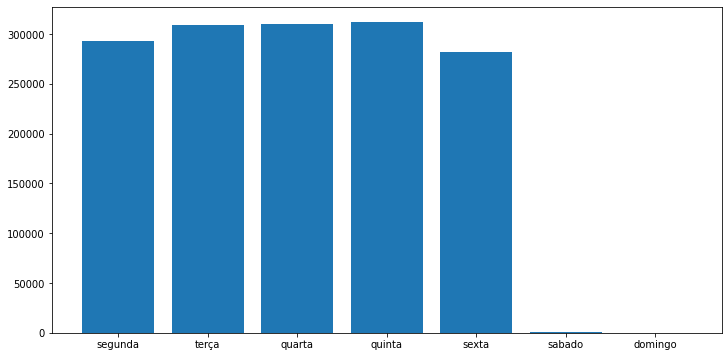

In [13]:
listadias = ['segunda','terça','quarta','quinta','sexta','sabado','domingo']
soma = [segunda,ter,quarta,quinta,sex,sab,domingo]
plt.figure(figsize=(12,6))
plt.bar(listadias,soma)


### o dia com mais entrada é quinta com 311922 infrações
### o dia com menos entrada é domingo com 228 infrações

#### 2. Calcular o total de infrações por semestre e ano

In [14]:
# extraindo as datas em uma série individual
datas = pd.Series(1, index=df['dat_entradasistema'])
datas

dat_entradasistema
2007-01-16    1
2007-01-18    1
2007-01-18    1
2007-01-18    1
2007-01-19    1
             ..
2013-06-28    1
2013-06-28    1
2013-06-28    1
2013-06-28    1
2013-06-28    1
Length: 1506280, dtype: int64

In [15]:
def text_above_bars(ax):
  '''
  Put text above bars of a bar plot
  '''
  rects = ax.patches  # cada rect é uma barra com atributos de posição, altura, largura, etc.
  for rect in rects:
      height = rect.get_height() # o atributo de altura do retângulo é o tamanho da barra
      label = int(height)
      ax.text(
          rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
      )
  return

In [17]:
# print da soma anual
anos = datas.resample('A', label='right').sum()
anos[::1]

dat_entradasistema
2007-12-31     84799
2008-12-31    191376
2009-12-31    294583
2010-12-31    292896
2011-12-31    283505
2012-12-31    231061
2013-12-31    128060
Freq: A-DEC, dtype: int64

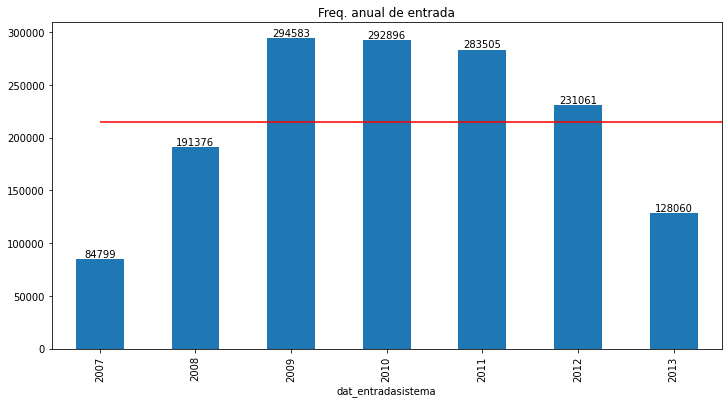

In [18]:
# redminsionando as datas para ano somando-se as ocorrências
plt.figure(figsize=(12,6))
plt.hlines(anos.mean(),0,300000, colors='r')
ax = datas.resample('A', label='right').sum().plot.bar(rot=90, title='Freq. anual de entrada')
ax.set_xticklabels(list(range(2007, 2014)))
# colocando as quantidades acima das barras 
text_above_bars(ax)

Text(0, 0.5, 'Número de ocorrências')

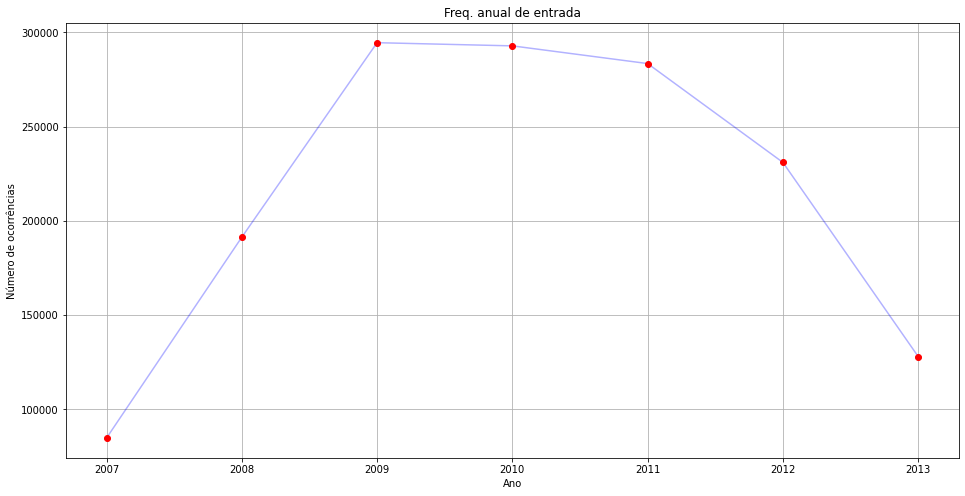

In [19]:
plt.figure(figsize=(16,8))
plt.plot([ano.year for ano in anos.index], anos.values, c='b', alpha=0.3)
plt.plot([ano.year for ano in anos.index], anos.values, 'o', c='r')
plt.grid()
plt.title('Freq. anual de entrada')
plt.xlabel('Ano')
plt.ylabel('Número de ocorrências')

In [20]:
# calculando a média anual de todo o período
anos.mean()

215182.85714285713

**Insight**: 2007 é o ano com menos multas.

**Insight**: o total de infrações por ano segue uma distribuição aproximadamente normal: o total de infrações por ano é simétrico em torno do 'eixo virtual' em 2010. O número de infrações cresce rapidamente até 2009; em seguida, existe uma queda no número de infrações ano após ano. O pico acontece em 2009 com 294.5k ocorrências.

**Insight**: o número médio anual de multas é aprox. 215k.

In [21]:
datas_sem_repeticao = datas.resample('D', label='right').count()
datas_sem_repeticao

dat_entradasistema
2007-01-17       1
2007-01-18       0
2007-01-19       3
2007-01-20       2
2007-01-21       0
              ... 
2013-06-25    1194
2013-06-26    1102
2013-06-27    1287
2013-06-28    1353
2013-06-29    1002
Freq: D, Length: 2356, dtype: int64

In [22]:
# total de dias em todo o período
datas_sem_repeticao.count()

2356

In [23]:
# média diária de infrações (todo o período)
media_diaria_todo_periodo = datas_sem_repeticao.mean()
print(media_diaria_todo_periodo)
# média diária de infrações (apenas dias com ocorrência)
media_diaria_apenas_dias_ocorrencia = datas_sem_repeticao[datas_sem_repeticao>0].mean()
print(media_diaria_apenas_dias_ocorrencia)

639.3378607809847
920.1466096518021


In [24]:
# total de dias sem ocorrência
datas_sem_repeticao[datas_sem_repeticao==0].count()

719

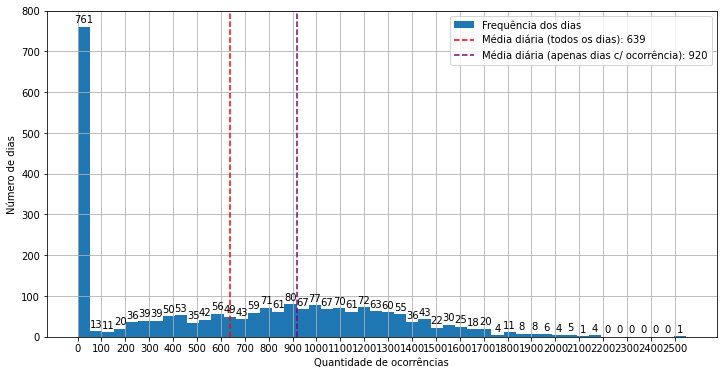

In [25]:
# criando uma figura
plt.figure(figsize=(12,6))
# criando o histograma de frequencias dos dias
ax = datas_sem_repeticao.hist(bins=50, label='Frequência dos dias')
# criando as retas verticais com as médoas
plt.vlines(media_diaria_todo_periodo, 0, 800, colors='r', linestyle='dashed', label=f'Média diária (todos os dias): {int(media_diaria_todo_periodo)}')
plt.vlines(media_diaria_apenas_dias_ocorrencia, 0, 800, colors='purple', linestyle='dashed', label=f'Média diária (apenas dias c/ ocorrência): {int(media_diaria_apenas_dias_ocorrencia)}')
# definindo o tamanho do eixo y
plt.ylim([0, 800])
# definindo os rótulos dos eixos
plt.ylabel('Número de dias')
plt.xlabel('Quantidade de ocorrências')
# colocando as quantidades acima das barras 
text_above_bars(ax)
# custom xticks
plt.xticks(np.arange(min(datas_sem_repeticao.values), max(datas_sem_repeticao.values)+1, 100))
# adicionando a legenda
plt.legend()

**Insight**: 719 dias (dos 2356) não possuem ocorrência de infração na base.

**Insight**: a média de ocorrências por dia (todo o período) é de 639, enquanto a média diária contando apenas os dias com ocorrência é de 920. O número máximo de ocorrências em um dia é de 2500; entretanto, existem poucos dias com mais de 1750 infrações. 

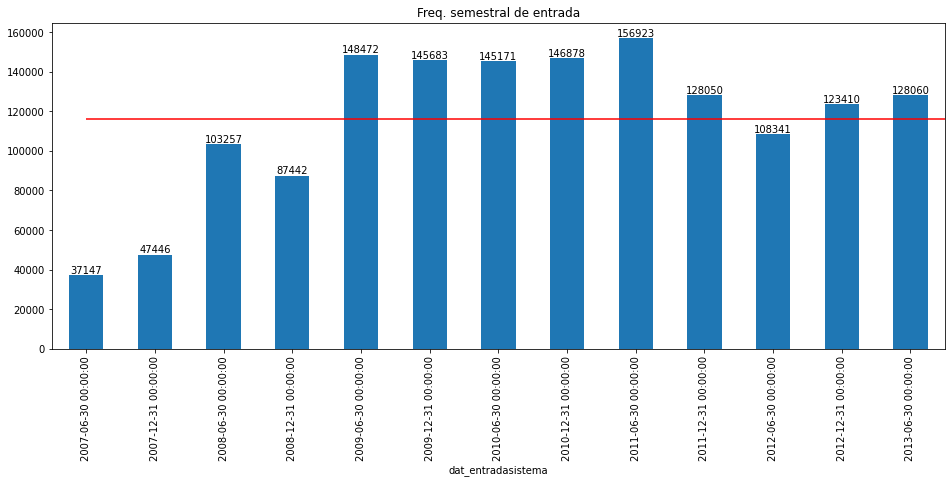

In [26]:
semestre = datas_sem_repeticao.resample('6m', label='right', closed='left').sum()
# redimensionando a base por semestres
plt.figure(figsize=(16,6))
plt.hlines(semestre.mean(),0,160000, colors='r')
ax = datas_sem_repeticao.resample('6m', label='right', closed='left').sum().plot.bar(rot=90, title='Freq. semestral de entrada')
# colocando as quantidades acima das barras 
text_above_bars(ax)

In [27]:
# frequencias de cada semestre (altura das barras no gráfico anterior)
datas_sem_repeticao.resample('6m', label='right', closed='left').sum()

dat_entradasistema
2007-06-30     37147
2007-12-31     47446
2008-06-30    103257
2008-12-31     87442
2009-06-30    148472
2009-12-31    145683
2010-06-30    145171
2010-12-31    146878
2011-06-30    156923
2011-12-31    128050
2012-06-30    108341
2012-12-31    123410
2013-06-30    128060
Freq: 6M, dtype: int64

**Insight**: O semestre com mais ocorrências é o 1o semestre de 2011. O semestre com menos ocorrências é o 1o semestre de 2007.

#### 3. Verificar quais condutores que mais tomaram multa por ano e no período total

Primeiramente, iremos identificar os 10 condutores e automóveis com mais multas por ano e no período completo.

In [28]:
cols = ['cod_condutorinfrator', 'num_auto']

def n_maiores_ano(df, col, n):
  # retorna os n elementos com maior número de ocorrências por ano
    print(f' *-*-*-*-* Relatório da coluna {col} *-*-*-*-*')
    anos = list(range(df['dat_entradasistema'].min().year, df['dat_entradasistema'].max().year+1))
    for ano in anos:
        boolean_mask = (df['dat_entradasistema'] > dt.datetime(ano, 1, 1)) & (df['dat_entradasistema'] < dt.datetime(ano+1, 1, 1))
        print('*-*-*'*5, ano, '*-*-*'*5)
        print(df[boolean_mask][col].value_counts()[:n])
    return

n_maiores_ano(df, cols[0], 10)

 *-*-*-*-* Relatório da coluna cod_condutorinfrator *-*-*-*-*
*-*-**-*-**-*-**-*-**-*-* 2007 *-*-**-*-**-*-**-*-**-*-*
84947     91
4299      66
85472     31
85464     27
80233     10
85476      9
84558      8
74881      7
138041     7
1127       6
Name: cod_condutorinfrator, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2008 *-*-**-*-**-*-**-*-**-*-*
204528    9
213675    8
331697    7
308038    7
237170    6
177799    6
171193    5
338062    5
266370    5
209850    5
Name: cod_condutorinfrator, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2009 *-*-**-*-**-*-**-*-**-*-*
483995    10
492565    10
356772     7
384585     6
397440     5
511879     5
430477     5
444955     5
356372     5
515582     5
Name: cod_condutorinfrator, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2010 *-*-**-*-**-*-**-*-**-*-*
829158    2
809781    2
810423    2
800126    2
806423    2
819756    2
843313    2
820185    2
844757    2
805594    2
Name: cod_condutorinfrator, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2011 *-*-**-*-**-*-*

**Insights**: o ano de 2007 se destaca por ter uma grade  quanntidade de infratores com muitas ocorrências. Interessantemente, esse é o ano com menor quantidade de infrações. A partir do ano de 2010, existem no máximo duas multas por infrator. 

In [29]:
n_maiores_ano(df, cols[1], 5)

 *-*-*-*-* Relatório da coluna num_auto *-*-*-*-*
*-*-**-*-**-*-**-*-**-*-* 2007 *-*-**-*-**-*-**-*-**-*-*
E000217565    2
E000214434    2
E000215988    2
E000217263    2
E000218839    2
Name: num_auto, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2008 *-*-**-*-**-*-**-*-**-*-*
B017820967    2
R197461492    2
R197483127    2
R197480667    2
R197453619    2
Name: num_auto, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2009 *-*-**-*-**-*-**-*-**-*-*
R208995811    2
R209050957    2
R209003227    2
R208997431    2
R209048786    2
Name: num_auto, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2010 *-*-**-*-**-*-**-*-**-*-*
R219460795    2
R219461708    2
R219455279    2
R219450827    2
R219448108    2
Name: num_auto, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2011 *-*-**-*-**-*-**-*-**-*-*
T030408527    2
E217174377    2
T030785207    2
T031888387    2
R232120056    2
Name: num_auto, dtype: int64
*-*-**-*-**-*-**-*-**-*-* 2012 *-*-**-*-**-*-**-*-**-*-*
T043350607    2
T042664241    2
T044651127    2
B122439422    2

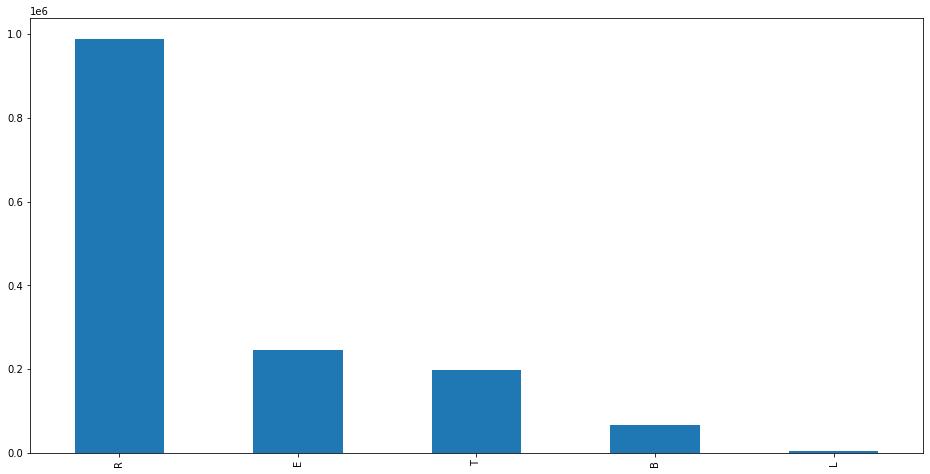

In [30]:
plt.figure(figsize=(16,8))
codes = {
    'B': 'PRF',
    'R': 'PRF',
    'E': 'PRF',
    'L': 'n identificado',
    'T': 'PRF',
}
df['num_auto'].apply(lambda x: x[0]).value_counts().plot.bar()

In [31]:
df['num_auto'].apply(lambda x: x[0]).value_counts()

R    989152
E    246557
T    198642
B     66511
L      5418
Name: num_auto, dtype: int64

**Insights**: não existe nenhum auto que tenha mais de 2 infrações no mesmo ano.

***Insights***: a grande maioria das multas vem da PRF; fonte: https://www.legisweb.com.br/legislacao/?id=200275.

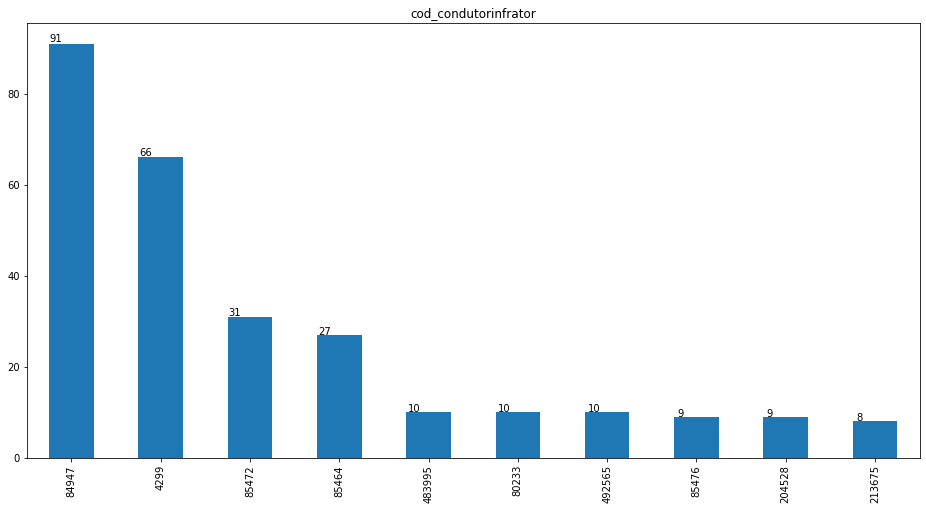

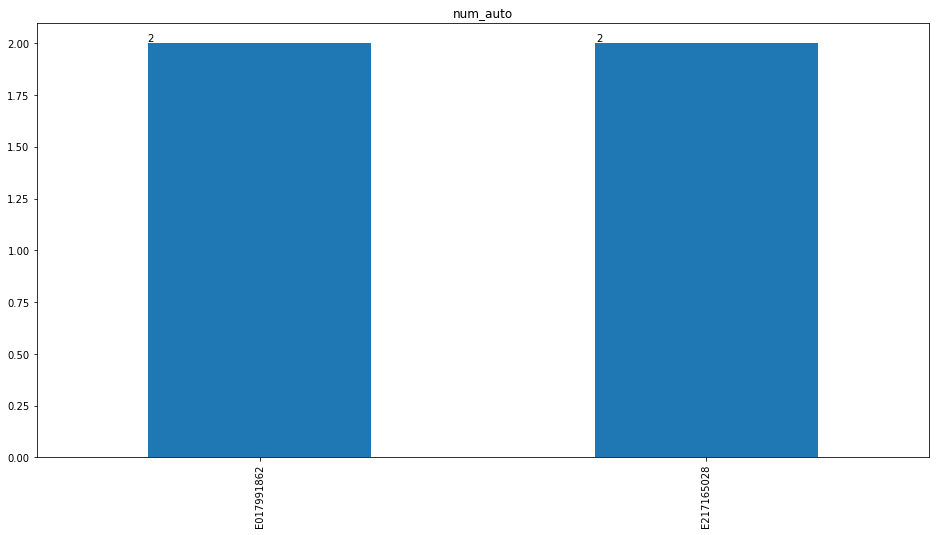

In [32]:
cols = ['cod_condutorinfrator', 'num_auto'] 
def n_mais_total(df, col, n):
    ax = plt.figure(figsize=(16,8))
    ax  = df[col].value_counts()[:n].plot.bar(rot=90, title=col)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    return
# 10 maiores infratores
n_mais_total(df, cols[0], 10)
# 2 automóveis que tomaram multa, nenhum automóvel ultrapaça duas infrações
n_mais_total(df, cols[1], 2)

#### 4. Verificar o número de semestres que ocorreram infrações para um mesmo condutor

In [33]:
df.head()

,cod_condutorinfrator,num_auto,dat_entradasistema
709266,60926,B084168595,2007-01-16
709804,61883,R005595142,2007-01-18
709120,61885,R005560647,2007-01-18
709798,61760,L002285924,2007-01-18
710221,61988,R005602277,2007-01-19


In [ ]:
def qtd_semester(x):
    res = pd.Series(1, index=x.values).resample('6m', label='right', closed='right').count()
    return res.size
#maior diferença entre uma multa e outra
def diff_days(x):
    res = pd.Series(1, index=x.sort_values(ascending=False).values)
    #res = res.sort_values(ascending=False) #.resample('6m', label='right', closed='right').count()
    first_date = res.index[0]; last_date = res.index[-1]
    #print(first_date, last_date)
    return (first_date - last_date).days # timedelta

b = df[['cod_condutorinfrator', 'dat_entradasistema']].groupby('cod_condutorinfrator').agg(diff_days)
b.sort_values('dat_entradasistema', ascending=False)

In [ ]:
(df['cod_condutorinfrator'].value_counts()>1).sum()

7165

In [ ]:
100*(df['cod_condutorinfrator'].value_counts()>1).sum()/(df['cod_condutorinfrator'].shape[0])

0.47567517327455716

**Insight**: Apenas 7165 (0.475%) infrações estão relacionadas a infratores com outras ocorrências. Aproximadamente 99.5% das ocorrências da base são de infratores com ocorrências únicas.

**Insight**: Existe no máximo 145 dias de diferença entre infrações de um mesmo condutor.

**Insights**: Não existem infrações de um mesmo condutor em semestres diferentes.

In [ ]:
datas_maior_infrator = df[df['cod_condutorinfrator']==84947]['dat_entradasistema']
datas_maior_infrator = pd.Series(1, index=datas_maior_infrator)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(datas_maior_infrator.sort_values())
  #verficar insight
dicmaior = {}
for x in df[df['cod_condutorinfrator']==84947]['dat_entradasistema']:
  if x in dicmaior:
    dicmaior[x]+=1
  else:
    dicmaior[x]=1
for key in dicmaior:
  print(key, dicmaior[key])

dat_entradasistema
2007-04-20    1
2007-05-18    1
2007-05-18    1
2007-05-18    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-17    1
2007-05-16    1
2007-05-16    1
2007-05-16    1
2007-05-15    1
2007-05-15    1
2007-05-18    1
2007-05-15    1
2007-05-18    1
2007-05-21    1
2007-05-22    1
2007-05-22    1
2007-05-22    1
2007-05-22    1
2007-05-22    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-21    1
2007-05-18    1
2007-05-22    1
2007-05-15    1
2007-05-15    1
2007-04-26    1
2007-04-25    1
2007-04-25    1
2007-04-25    1
2007-04-24    1
2007-04-24    1
2007-04-24    1
2007-04-23    1
2007-04-23    1
2007-04-23    1
2007-04-23    1
2007-04-23    1
2007-04-23    1
2007-04-23    1
2007-

#### verificar a diferença entre 2007 e 2008 e 2007.1 e 2008.1

Por ano:

In [ ]:
# código revisitado
x = datas.resample('Y').sum()
filtered2007 = x[0]
filtered2008 = x[1]
print(f"Contagem ano 2007 \n{filtered2007}")
print(20*"-")
print(f"Contagem ano 2008 \n{filtered2008}")
print(20*"-")
diff = filtered2008-filtered2007
print(f"Diferença entre 2007 e 2008 \n{diff}")
print(20*"-")
print('% das ocorrências de 2007 com relação as de 2008')
print("%.2f "%(filtered2007*100/filtered2008)+'%')
print(20*"-")
print('Diferença em %')
print("%.2f "%(diff*100/filtered2008)+'%')

Contagem ano 2007 
84799
--------------------
Contagem ano 2008 
191376
--------------------
Diferença entre 2007 e 2008 
106577
--------------------
% das ocorrências de 2007 com relação as de 2008
44.31 %
--------------------
Diferença em %
55.69 %


Por semestre:

In [ ]:
semestres = datas_sem_repeticao.resample('6m', label='right', closed='left').sum()
filtered2007 = semestres[0]
filtered2008 = semestres[2]
print(f"Contagem ano 2007 1° semestre \n{filtered2007}")
print(20*"-")
print(f"Contagem ano 2008 1° semestre \n{filtered2008}")
print(20*"-")
diff = filtered2008-filtered2007
print(f"Diferença entre 2007 e 2008 (apenas 1o semestre) \n{diff}")
print(20*"-")
print('% das ocorrências de 2007 com relação as de 2008 (apenas 1o semestre) ')
print("%.2f "%(filtered2007*100/filtered2008)+'%')
print(20*"-")
print('Diferença em % (apenas  1o semestre) ')
print("%.2f "%(diff*100/filtered2008)+'%')
#verificar trocar resample
datas_sem_repeticao.resample('6m', label='right', closed='left').sum()

Contagem ano 2007 1° semestre 
37147
--------------------
Contagem ano 2008 1° semestre 
103257
--------------------
Diferença entre 2007 e 2008 (apenas 1o semestre) 
66110
--------------------
% das ocorrências de 2007 com relação as de 2008 (apenas 1o semestre) 
35.98 %
--------------------
Diferença em % (apenas  1o semestre) 
64.02 %


dat_entradasistema
2007-06-30     37147
2007-12-31     47446
2008-06-30    103257
2008-12-31     87442
2009-06-30    148472
2009-12-31    145683
2010-06-30    145171
2010-12-31    146878
2011-06-30    156923
2011-12-31    128050
2012-06-30    108341
2012-12-31    123410
2013-06-30    128060
Freq: 6M, dtype: int64

#### Testar se a média de fim de semana e feriados é maior do que a média de segunda à sexta

In [ ]:
lista_feriados = []
for ano in range(2007, 2014):
    lista_feriados.extend(holidays.Brazil()[f'{ano}-01-01': f'{ano}-12-31'])

In [ ]:
period_range = pd.date_range(start=df['dat_entradasistema'].min().strftime("%Y-%m-%d"), 
              end=df['dat_entradasistema'].max().strftime("%Y-%m-%d"))
period_range[:5]
#verificar

DatetimeIndex(['2007-01-16', '2007-01-17', '2007-01-18', '2007-01-19',
               '2007-01-20'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
mask_weekdays = period_range.map(lambda x: 1 if x.weekday() <5 else 0).map(lambda x: bool(x))
mask_weekdays= np.array(mask_weekdays).astype(bool)
lista_dias_semana = list(np.array(period_range)[mask_weekdays])
#lista_dias_semana

In [ ]:
mask_weekends = period_range.map(lambda x: 1 if x.weekday() >=5 else 0).map(lambda x: bool(x))
mask_weekends= np.array(mask_weekends).astype(bool)
lista_fins_semana = list(np.array(period_range)[mask_weekends])
#lista_fins_semana.shape
#verificar

In [ ]:
### listas em um mesmo formato: datetime.datetime
lista_feriados = [pd.Timestamp(data).to_pydatetime() for data in lista_feriados]
lista_dias_semana = [pd.Timestamp(data).to_pydatetime() for data in lista_dias_semana]
lista_fins_semana = [pd.Timestamp(data).to_pydatetime() for data in lista_fins_semana]
#verificar

In [ ]:
feriados_dias_semana = list(set(lista_feriados) & set(lista_dias_semana))
lista_dias_semana_sem_feriados = list(set(lista_dias_semana) - set(feriados_dias_semana))
lista_fins_semana_sem_feriados = list(set(lista_fins_semana) - set(feriados_dias_semana))
#verificar

In [ ]:
def numero_medio(dff, lista, nome):
    dff_filtered = dff['dat_entradasistema'][dff['dat_entradasistema'].apply(lambda x: x.to_pydatetime() in lista)]
    print('Numero de ocorrencias: ', dff_filtered.shape[0])
    media_datas_com_infracao = dff_filtered.size/dff_filtered.nunique()
    print(f'{media_datas_com_infracao}: Numero médio de infrações nos {nome} que contém infrações.')
    media_datas_todo_periodo = dff_filtered.size/len(lista)
    print(f'{media_datas_todo_periodo}: Numéro médio de infrações por {nome} existente em todo o período osbervado')
    return

In [ ]:
numero_medio(df, lista_feriados, 'feriados')

Numero de ocorrencias:  1557
129.75: Numero médio de infrações nos feriados que contém infrações.
17.10989010989011: Numéro médio de infrações por feriados existente em todo o período osbervado


In [ ]:
numero_medio(df, lista_dias_semana_sem_feriados, 'dias_semana')

Numero de ocorrencias:  1503540
940.3001876172608: Numero médio de infrações nos dias_semana que contém infrações.
928.1111111111111: Numéro médio de infrações por dias_semana existente em todo o período osbervado


In [ ]:
numero_medio(df, lista_fins_semana, 'fins_semana')

Numero de ocorrencias:  1183
45.5: Numero médio de infrações nos fins_semana que contém infrações.
1.7604166666666667: Numéro médio de infrações por fins_semana existente em todo o período osbervado


In [ ]:
1-df['dat_entradasistema'].nunique()/(6.5*365)

0.3100105374077977

In [ ]:
len([data.to_pydatetime() for data in datas_sem_repeticao.index if data in lista_feriados])

85

In [ ]:
len(lista_feriados)

91

In [ ]:
len([data.to_pydatetime() for data in datas_sem_repeticao.index])

2356

In [ ]:
(datas_sem_repeticao>0).sum()/len([data.to_pydatetime() for data in datas_sem_repeticao.index])

0.6948217317487266

In [ ]:
df.shape[0]/df['dat_entradasistema'].nunique()

920.1466096518021

**Insight**: Não exsistem ocorrências em 31% dos dias em todo o períodode 2007 à 2013.

**Insight**: existem 91 feriados no período, porém apenas 85 deles com registro de ocorrência.

**Insight**: De 2356 dias totais, tem-se apenas 1637 (69%) de dias com ocorrências. O total de infrações nesse período é de aprox. 1.5M, o que faz que em média, 920 ocorrências ocorram por dia.

**Insight**: Existe diferença notável do numero de ocorrências médio entre dias de semana, feriados e finais de semana. Dias de semana têm uma ocorrência diária média muito maior do que essa estatística em fins de semana e feriados (considerando as datas registradas). Além disso, a média de infrações considerando todos os dias de semana dentro de todo o período observado diminui pouco, o que indica que há poucos dias de semana sem infrações. Em contrapartida, ocorrências em dias de feriado e fins de semana são escassas, o que faz com que a média considerando o período total diminui bastante com relação aos dias com infração. Interessantemente, dias de feriado têm mais infrações que dias de fins de semana.  

#### 2. Teste de hipótese

Existe diferença no número de infrações entre segundas e sextas feiras de uma mesma semana?

In [ ]:
datas.index

DatetimeIndex(['2007-01-16', '2007-01-18', '2007-01-18', '2007-01-18',
               '2007-01-19', '2007-01-19', '2007-01-22', '2007-01-22',
               '2007-01-22', '2007-01-22',
               ...
               '2013-06-28', '2013-06-28', '2013-06-28', '2013-06-28',
               '2013-06-28', '2013-06-28', '2013-06-28', '2013-06-28',
               '2013-06-28', '2013-06-28'],
              dtype='datetime64[ns]', name='dat_entradasistema', length=1506280, freq=None)

In [ ]:
def infracoes_dia_semana(datas, id_week):
    dt = sum(list(datas.index.map(lambda x: x.weekday() == id_week)))
    return dt

In [ ]:
df_mondays = datas.resample('W').apply(lambda x: infracoes_dia_semana(x, 0))
df_mondays

dat_entradasistema
2007-01-21       0
2007-01-28      12
2007-02-04      84
2007-02-11     207
2007-02-18     338
              ... 
2013-06-02    1164
2013-06-09     910
2013-06-16    1377
2013-06-23     637
2013-06-30    1194
Freq: W-SUN, Length: 337, dtype: int64

In [ ]:
df_fridays = datas.resample('W').apply(lambda x: infracoes_dia_semana(x, 4))
df_fridays.sum()

282017

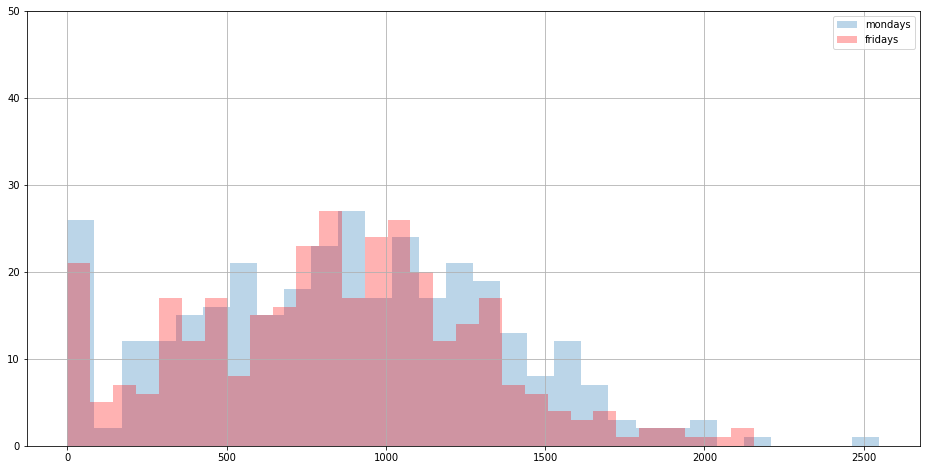

In [ ]:
ax = plt.figure(figsize=(16,8))
df_mondays.hist(bins=30, alpha=0.3, label='mondays')
df_fridays.hist(bins=30, alpha=0.3, color='r', label='fridays')
plt.ylim(0,50)
plt.legend()

In [ ]:
A = np.array(df_mondays)
B = np.array(df_fridays)
print(A.mean())

868.1691394658753


In [ ]:
B.mean()

836.8456973293769

**Insight**: as distribuições de infrações nas segundas e sextas são similares.

#### Modelo de regressão preditivo para prever a quantidade de multas da sexta com base nas multas de seg a sexta

In [ ]:
# removendo 1o mes:  poucos dados
boolean_mask = (df['dat_entradasistema'] > dt.datetime(2007, 2, 1)) & (df['dat_entradasistema'] < dt.datetime(2013, 7, 1))
dft = df[boolean_mask]
dft.head()

,cod_condutorinfrator,num_auto,dat_entradasistema
1497178,66583,R005672929,2007-02-02
1495236,64095,R005572142,2007-02-02
1496118,66457,R005613159,2007-02-02
1498823,66651,R005797101,2007-02-02
1496132,66516,R005616367,2007-02-02


In [ ]:
# criando dados de treinamennto/teste
# treinamento: dados semanais (divididos por dia  semana) de fev/2007 até jun/2013
data = []
#df = df['dat_entradasistema']
for week_day in range(5): # monday - friday
    res = dft['dat_entradasistema'][dft['dat_entradasistema'].apply(lambda x: True if (x.weekday() == week_day) else False)]
    values = pd.Series(1, index=res).resample('w').count()
    data.append({"day": week_day, "weekly_occurences": values})
data

[{'day': 0, 'weekly_occurences': dat_entradasistema
  2007-02-11     207
  2007-02-18     338
  2007-02-25       0
  2007-03-04     273
  2007-03-11     457
                ... 
  2013-06-02    1164
  2013-06-09     910
  2013-06-16    1377
  2013-06-23     637
  2013-06-30    1194
  Freq: W-SUN, Length: 334, dtype: int64},
 {'day': 1, 'weekly_occurences': dat_entradasistema
  2007-02-11     178
  2007-02-18     304
  2007-02-25       0
  2007-03-04     238
  2007-03-11     448
                ... 
  2013-06-02    1008
  2013-06-09    1202
  2013-06-16    1111
  2013-06-23     590
  2013-06-30    1102
  Freq: W-SUN, Length: 334, dtype: int64},
 {'day': 2, 'weekly_occurences': dat_entradasistema
  2007-02-11     331
  2007-02-18     369
  2007-02-25     112
  2007-03-04     208
  2007-03-11     422
                ... 
  2013-06-02    1179
  2013-06-09     789
  2013-06-16    1625
  2013-06-23     462
  2013-06-30    1287
  Freq: W-SUN, Length: 334, dtype: int64},
 {'day': 3, 'weekly_oc

In [ ]:
#  numero de dias no conjunto de treinamento
(data[0]['weekly_occurences'].index<dt.datetime(2012, 7, 1)).sum()

281

In [ ]:
# número de occorrências para cada dia da semana
print([d['weekly_occurences'].size for d in data])  # sexta feira tem uma semana a mais (remover abaixo)

[334, 334, 334, 334, 335]


In [ ]:
# 334: # total semanas
# 281: # semanas até julho de 2012 (treinamento)
X_train = np.ones([281, 4])
y_train = np.ones(281)
X_test =  np.ones([334-281, 4])
y_test = np.ones(334-281)
for day in data:
    col = day['day']
    history = day['weekly_occurences']
    if col == 4: # sexta-feira tem um dado a mais no início do período
        y_train = np.array(history[1:282]) # removing the first occurence 
        y_test = np.array(history[282:])
    else:
        X_train[:,col] = history[:281]
        X_test[:,col] = history[281:]

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(281, 4)
(53, 4)
(281,)
(53,)


In [ ]:
# instanciando um modelo linear  
linreg = linear_model.LinearRegression(fit_intercept=True)
# treinando
linreg.fit(X_train, y_train)

LinearRegression()

In [ ]:
print(linreg.coef_) # coeficientes (segunda, terça, quarta, quinta)
print(linreg.intercept_) # intercepto
# gerando valores para cada semana no conjunto de teste
y_pred = linreg.predict(X_test)

[0.07690987 0.0943208  0.21421778 0.33684899]
177.7719056390041


In [ ]:
# entrada personalizada p/ teste
entrada = [250, 100, 400, 333] # payload
entradarada_processada = np.array(entrada).reshape(1,-1) # dentro da API
y_teste = linreg.predict(entradarada_processada) # prediction
y_teste

array([404.28927914])

In [ ]:
# avaliando o modelo no conjunto de teste
RMSE = np.sqrt(((y_test-y_pred)**2).mean())
MAE = np.abs(y_test-y_pred).mean()
R2 = linreg.score(X_test,  y_test)
print(RMSE, MAE,  R2)

342.9469814455292 252.80298974680298 0.06914192963732291


In [ ]:
# avaliando o modelo no conjunto de treinamento
y_pred_train = linreg.predict(X_train)
RMSE_train = np.sqrt(((y_pred_train-y_train)**2).mean())
MAE_train = np.abs(y_pred_train-y_train).mean()
print(RMSE_train, MAE_train)

350.57329362527366 248.21464569402633


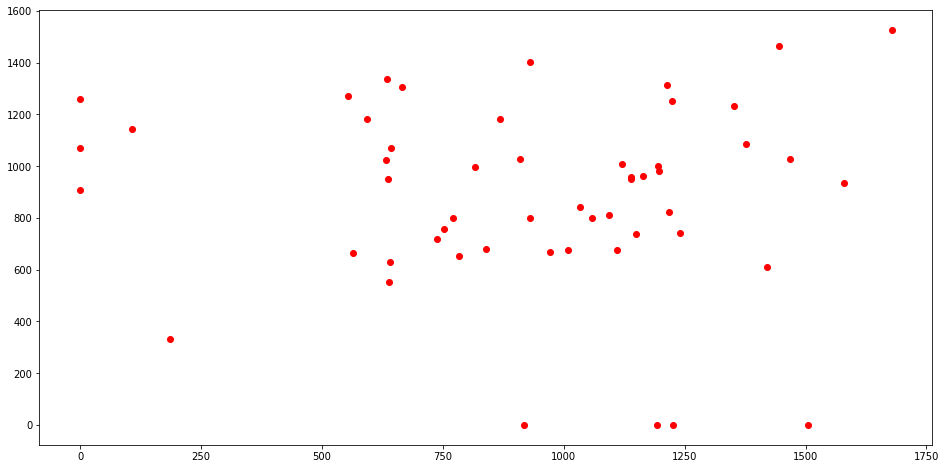

In [ ]:
# avaliando a relação entre as ocorrências de segunda feira e sexta feira no conjunto de teste
plt.figure(figsize=(16,8))
plt.plot(X_test[:,0], y_test, 'ro')

#### Insights:
 - Não há overfitting: a performance do modelo no conjunto de treinamento é similar ao esperado para dados não observados.
 -  Performance ruim (altos valores de RMSE e MAE)
 - Baixa qualidade da  linha de regressão (R^2 ~ 7%)